number of clusters = 2 , Dunn_index = 0.46788171698063663
number of clusters = 3 , Dunn_index = 0.615960328861369
number of clusters = 4 , Dunn_index = 0.5713682843837296
number of clusters = 5 , Dunn_index = 0.37988638038242983


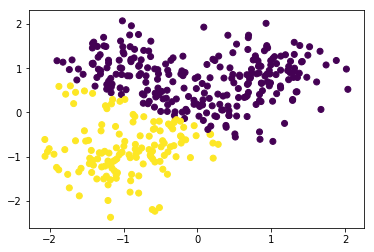

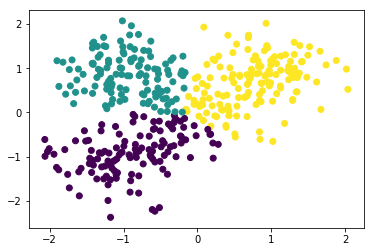

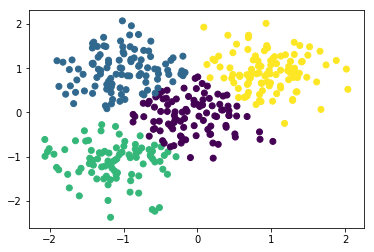

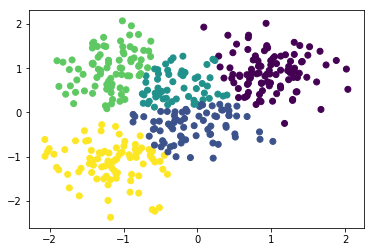

In [155]:
import pandas as pd
import operator
import time
import random
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
random.seed(0)

df = pd.read_csv('/Users/dashabalashova/1_1_5_ML_Bioinf/data/blobs.csv')

def split_into_clusters(df, centers, K):
    #print(centers)
    d = df
    for k in range(0,K):
        d1 = (df - np.array(centers.iloc[k])).pow(2).sum(1).pow(0.5)
        d = pd.concat([d, d1], axis=1)
    d.columns = ['x','y'] + list(range(0, K))
    e = d[list(range(0, K))].idxmin(axis=1)
    d = pd.concat((d, e.rename('cluster')), axis=1)[['x','y','cluster']]
    new_centers = d.groupby(['cluster']).mean()
    #print('new=', new_centers)
    a = sum((centers-new_centers).pow(2).sum(1).pow(0.5))
    #print(a)
    return d, new_centers, a


def main(K):
    a=1
    centers = []
    for n in random.sample(range(1, df.shape[0]+1), K):
        centers.append(list(df.iloc[n]))    
    centers = pd.DataFrame(centers, columns=['x','y'])
    while a>0.01:
        d, centers, a = split_into_clusters(df, centers, K)
        #print(a)
    d['cluster'] = pd.to_numeric(d['cluster'])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    scatter = ax.scatter(d[['x']], d[['y']], c=np.array(d[['cluster']]))
    return d

def dist(n, d):
    df=d[d['cluster']==n].reset_index(drop=True)
    df=df.rename(str.lower, axis='columns')
    l=df.shape[0]
    T = KDTree(df)
    di = []
    for t in df.index:
        v1=df.loc[t]
        di.append(T.query(v1, k=l)[0][-1])
    return max(di), list(df.mean()[['x','y']])

def Dunn_index(d):
    st_1=[]
    st_2=[]
    st_3 = []
    for n in d.groupby('cluster').count().index:
        if n>=0:
            a=dist(n, d)
            st_1.append(a[0])
            st_2.append(np.array(a[1]))
    for n in range(0,len(st_1)):
        for m in range(n+1,len(st_1)):
            st_3.append(np.linalg.norm(st_2[n]-st_2[m]))
    return min(st_3)/max(st_1)


for n in range(2,6):
    d = main(n) 
    print('number of clusters =', n, ', Dunn_index =',Dunn_index(d))

number of clusters = 4 , Dunn_index = 0.8318197512089751


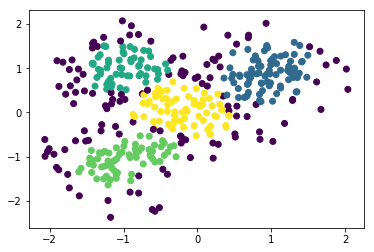

In [159]:
import pandas as pd
import operator
import time
import random
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
random.seed(0)


df = pd.read_csv('/Users/dashabalashova/1_1_5_ML_Bioinf/data/blobs.csv')
T = KDTree(df)

def find_neib(d, n, cl, R, M):
    d.at[n,'type'] = 'known'
    X_neib2 = T.query_ball_point(d.iloc[n][['X','Y']], r = R)
    if len(X_neib2)>M:
        for m in X_neib2:
            d.at[m,'cluster'] = cl
            if d.at[m,'type'] == 'unknown':
                find_neib(d, m, cl, R, M)
    return d

def main(d, M, R):
    d.insert(0, 'type', 'unknown')
    d.insert(0, 'cluster', -1)
    u=0
    k=0
    stop=0
    while stop!=1:
        d = find_neib(d, k, u, R, M)
        if len(d.index[d['type']=='unknown'])>0:
            k = d.index[d['type']=='unknown'][0]
        else:
            stop=1
        u+=1
    fig = plt.figure()
    ax = fig.add_subplot(111)
    scatter = ax.scatter(d[['X']], d[['Y']], c=np.array(d[['cluster']]))
    return d[['X','Y','cluster']]

d = main(df, 30, 0.4)


print('number of clusters =', 4, ', Dunn_index =',Dunn_index(d))

number of clusters = 5 , Dunn_index = 0.3656480032057106
number of clusters = 4 , Dunn_index = 0.5517825988271159
number of clusters = 3 , Dunn_index = 0.2183891771611067
number of clusters = 2 , Dunn_index = 0.3633299805723616


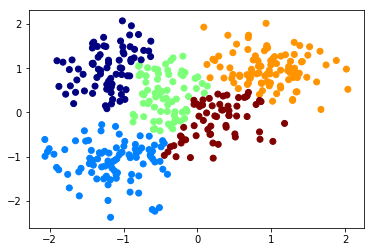

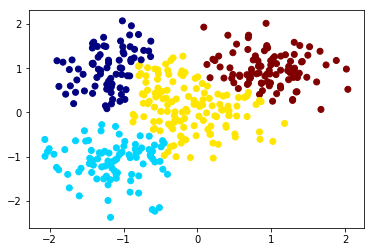

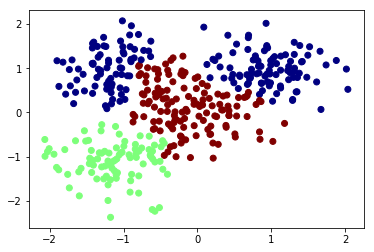

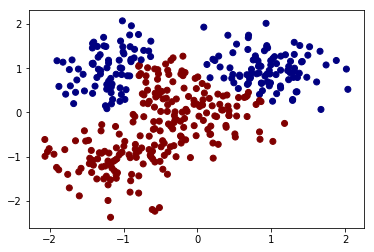

In [368]:
import matplotlib.cm as cm

df = pd.read_csv('/Users/dashabalashova/1_1_5_ML_Bioinf/data/blobs.csv')

#print(df.shape[0])
df.insert(0, 'cluster',list(range(0,df.shape[0])))
df = df.rename(str.lower, axis='columns')
di = pd.DataFrame()
for m in range(0,df.shape[0]):
    for n in range(0,df.shape[0]):
        if m>n:
            di.at[m,n]=dist_1(m, n, df)
#print(di)

def dist_1(m, n, d):
    df = d[(d['cluster']==m) | (d['cluster']==n)].reset_index(drop=True)
    df = df.rename(str.lower, axis='columns')
    df = df.drop(['cluster'], axis=1)
    l=df.shape[0]
    T = KDTree(df)
    di = []
    for t in df.index:
        v1=df.loc[t]
        di.append(T.query(v1, k=l)[0][-1])
    return max(di)


            
def step(di, df, K):            
    for l in range(0, K):
        di=di.sort_index(axis=1)
        a, b = di.stack().idxmin()
        df.loc[df['cluster'] == a, 'cluster'] = b
        di=di.drop([a], axis=0)
        di=di.drop([b], axis=1)
        if b in di.index.values:
            di=di.drop([b], axis=0)
        if a in di.columns.values:
            di=di.drop([a], axis=1)
        for m in df['cluster'].unique():
            if m>b:
                di.at[m,b]=dist_1(m, b, df)
            if m<b:
                di.at[b,m]=dist_1(b, m, df)
    df['cluster'] = pd.to_numeric(df['cluster'])
    dict_c={}
    e=df['cluster'].unique()
    for n in range(0,len(e)):
        dict_c[e[n]]=n*125
    
    df['cluster_c'] = df.apply(lambda row: dict_c[row['cluster']], axis=1)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    scatter = ax.scatter(df[['x']], df[['y']], c=np.array(df[['cluster_c']]), cmap='jet')
    return di, df


di, df = step(di, df, df.shape[0]-5)
print('number of clusters =', 5, ', Dunn_index =',Dunn_index(df))
#print(df)
di, df = step(di, df, 1)
print('number of clusters =', 4, ', Dunn_index =',Dunn_index(df))
di, df = step(di, df, 1)
print('number of clusters =', 3, ', Dunn_index =',Dunn_index(df))
di, df = step(di, df, 1)
print('number of clusters =', 2, ', Dunn_index =',Dunn_index(df))
